Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<p align="center">
  <h1 align="center">TAPIR: Tracking Any Point with per-frame Initialization and temporal Refinement</h1>
  <p align="center">
    <a href="http://www.carldoersch.com/">Carl Doersch</a>
    ·
    <a href="https://yangyi02.github.io/">Yi Yang</a>
    ·
    <a href="https://scholar.google.com/citations?user=Jvi_XPAAAAAJ">Mel Vecerik</a>
    ·
    <a href="https://scholar.google.com/citations?user=cnbENAEAAAAJ">Dilara Gokay</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~ankush/">Ankush Gupta</a>
    ·
    <a href="http://people.csail.mit.edu/yusuf/">Yusuf Aytar</a>
    ·
    <a href="https://scholar.google.co.uk/citations?user=IUZ-7_cAAAAJ">Joao Carreira</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~az/">Andrew Zisserman</a>
  </p>
  <h3 align="center"><a href="https://arxiv.org/abs/2306.08637">Paper</a> | <a href="https://deepmind-tapir.github.io">Project Page</a> | <a href="https://github.com/deepmind/tapnet">GitHub</a> | <a href="https://github.com/deepmind/tapnet/tree/main#running-tapir-locally">Live Demo</a> </h3>
  <div align="center"></div>
</p>

<p align="center">
  <a href="">
    <img src="https://storage.googleapis.com/dm-tapnet/swaying_gif.gif" alt="Logo" width="50%">
  </a>
</p>



In [22]:
# @title Install code and dependencies {form-width: "25%"}
!pip install git+https://github.com/google-deepmind/tapnet.git

  Cloning https://github.com/google-deepmind/tapnet.git to /tmp/pip-req-build-qp_2sxks
  Running command git clone --filter=blob:none --quiet https://github.com/google-deepmind/tapnet.git /tmp/pip-req-build-qp_2sxks
  Resolved https://github.com/google-deepmind/tapnet.git to commit 26c86c84a81c7487f7ea6c27f939904b9736da31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
MODEL_TYPE = 'bootstapir' # 'tapir' or 'bootstapir'

In [ ]:
# @title Download Model {form-width: "25%"}

%mkdir tapnet/checkpoints

if MODEL_TYPE == 'tapir':
  !wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy
else:
  !wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/bootstap/causal_bootstapir_checkpoint.npy

%ls tapnet/checkpoints

In [ ]:
# @title Imports {form-width: "25%"}
%matplotlib widget
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from tqdm import tqdm
import tree

from tapnet.models import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils
from tapnet.utils import model_utils

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# @title Load Checkpoint {form-width: "25%"}

if MODEL_TYPE == 'tapir':
  checkpoint_path = 'tapnet/checkpoints/causal_tapir_checkpoint_panning.npy'
else:
  checkpoint_path = 'tapnet/checkpoints/causal_bootstapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

kwargs = dict(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False, pyramid_level=0)
if MODEL_TYPE == 'bootstapir':
  kwargs.update(dict(
    pyramid_level=1,
    extra_convs=True,
    softmax_temperature=10.0
  ))
tapir = tapir_model.ParameterizedTAPIR(params, state, tapir_kwargs=kwargs)

In [ ]:
# @title Build Model {form-width: "25%"}

# Internally, the tapir model has three stages of processing: computing
# image features (get_feature_grids), extracting features for each query point
# (get_query_features), and estimating trajectories given query features and
# the feature grids where we want to track (estimate_trajectories).  For
# tracking online, we need extract query features on the first frame only, and
# then call estimate_trajectories on one frame at a time.

def online_model_init(frames, query_points):
  """Initialize query features for the query points."""
  frames = model_utils.preprocess_frames(frames)
  feature_grids = tapir.get_feature_grids(frames, is_training=False)
  query_features = tapir.get_query_features(
      frames,
      is_training=False,
      query_points=query_points,
      feature_grids=feature_grids,
  )
  return query_features

online_model_init=jax.jit(online_model_init)

def online_model_predict(frames, query_features, causal_context):
  """Compute point tracks and occlusions given frames and query points."""
  frames = model_utils.preprocess_frames(frames)
  feature_grids = tapir.get_feature_grids(frames, is_training=False)
  trajectories = tapir.estimate_trajectories(
      frames.shape[-3:-1],
      is_training=False,
      feature_grids=feature_grids,
      query_features=query_features,
      query_points_in_video=None,
      query_chunk_size=64,
      causal_context=causal_context,
      get_causal_context=True,
  )
  causal_context = trajectories['causal_context']
  del trajectories['causal_context']
  # Take only the predictions for the final resolution.
  # For running on higher resolution, it's typically better to average across
  # resolutions.
  tracks = trajectories['tracks'][-1]
  occlusions = trajectories['occlusion'][-1]
  uncertainty = trajectories['expected_dist'][-1]
  visibles = model_utils.postprocess_occlusions(occlusions, uncertainty)
  return tracks, visibles, causal_context

online_model_predict=jax.jit(online_model_predict)

In [ ]:
# @title Utility Functions {form-width: "25%"}

def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points

In [27]:
# @title Load an Exemplar Video {form-width: "25%"}

%mkdir tapnet/examplar_videos

!wget -P tapnet/examplar_videos https://vlmimic.github.io/static/videos/11_brush_pan4X.mp4

video = media.read_video('tapnet/examplar_videos/11_brush_pan4X.mp4')
height, width = video.shape[1:3]
media.show_video(video, fps=10)

mkdir: cannot create directory ‘tapnet/examplar_videos’: File exists
--2024-10-24 08:57:50--  https://vlmimic.github.io/static/videos/11_brush_pan4X.mp4
Resolving vlmimic.github.io (vlmimic.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to vlmimic.github.io (vlmimic.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643651 (629K) [video/mp4]
Saving to: ‘tapnet/examplar_videos/11_brush_pan4X.mp4’

11_brush_pan4X.mp4  100%[===================>] 628.57K  --.-KB/s    in 0.04s   

2024-10-24 08:57:50 (16.0 MB/s) - ‘tapnet/examplar_videos/11_brush_pan4X.mp4’ saved [643651/643651]



In [ ]:
# @title Progressively Predict Sparse Point Tracks {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}
num_points = 20  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_random_points(0, frames.shape[1], frames.shape[2], num_points)

# Extract features for the query point.
query_features = online_model_init(frames[None, 0:1], query_points[None])

# We need a causal state for every PIPs resolution; therefore,
# construct_initial_causal_state's second param is the number of resolutions.
# query_features.resolutions is one more than the number of PIPs resolutions
# (since there's an 'initialization' resolution as well).
# Of course, since we're running at 256x256 in this demo, there will only be
# one PIPs resolution.
#
# Note that causal_state can also be initialized to None, but this will mean
# online_model_predict gets compiled twice.
causal_state = tapir.construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  # Note: we add a batch dimension.
  tracks, visibles, causal_state = online_model_predict(
      frames=frames[None, i:i+1],
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append({'tracks':tracks, 'visibles':visibles})

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
visibles = np.concatenate([x['visibles'][0] for x in predictions], axis=1)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.plot_tracks_v2(video, tracks, np.logical_not(visibles))
media.show_video(video_viz, fps=10)

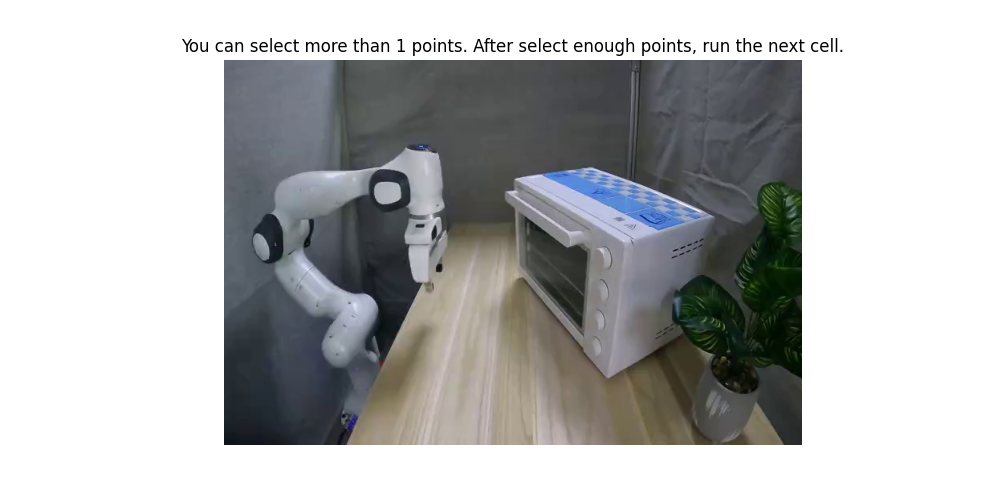

In [25]:
# @title Select Any Points at First Frame {form-width: "25%"}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[0])
ax.axis('off')
ax.set_title('You can select more than 1 points. After select enough points, run the next cell.')

select_points = []

 # Event handler for mouse clicks
def on_click(event):
  if event.button == 1 and event.inaxes == ax:  # Left mouse button clicked
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

    select_points.append(np.array([x, y]))

    color = colormap[len(select_points) - 1]
    color = tuple(np.array(color) / 255.0)
    ax.plot(x, y, 'o', color=color, markersize=5)
    plt.draw()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [26]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], [t, y, x]
  Returns:
    query_points: [num_points, 3], [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(0, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')

query_features = online_model_init(frames[None, 0:1], query_points[None])
causal_state = tapir.construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  # Note: we add a batch dimension.
  tracks, visibles, causal_state = online_model_predict(
      frames=frames[None, i:i+1],
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append({'tracks':tracks, 'visibles':visibles})

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
visibles = np.concatenate([x['visibles'][0] for x in predictions], axis=1)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)
media.show_video(video_viz, fps=10)

That's it!